# Self-Driving Car Engineer Nanodegree

## Testing pre-trained models

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Define Functions

In [2]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
def rgb2Grey(rgbImage,weights=[1.0,1.0,1.0]):
    """simple multi-channel to 1 channel conversion"""
    
    return np.dot(rgbImage[...,:3], weights)

def applyRGBThresholds(img,rgbThreshold=[0,0,0]):
    colorSelect = np.copy(img)
    imgThresholds = (img[:,:,0] < rgbThreshold[0]) \
                | (img[:,:,1] < rgbThreshold[1]) \
                | (img[:,:,2] < rgbThreshold[2])
    colorSelect[imgThresholds] = [0,0,0]
    
    return colorSelect

def applyGreyThresholds(img,thresholds=[0,255]):
    greySelect = np.copy(img)
    
    # lower bounds
    lowThresholds = (img[:,:] < thresholds[0])
    greySelect[lowThresholds] = 0
    
    # upper bounds
    highThresholds = (img[:,:] > thresholds[1])
    greySelect[highThresholds] = 255
    
    return greySelect

def imageViz(img,label=""):
    figure, axes = plt.subplots(nrows=3,ncols=4,figsize=(8,8))
    
    #show raw image
    figure.text(0,1,label)
    axes[0][0].imshow(img)

    # check image against each of the color channels
    #for i in range(1,4):
    #    axes[1][i].imshow(img[:,:,i-1],cmap=plt.cm.Greys_r)

    # rgb thresholding
    axes[0][1].imshow(applyRGBThresholds(img,rgbThreshold=[100,0,0]))
    axes[0][2].imshow(applyRGBThresholds(img,rgbThreshold=[0,100,0]))
    axes[0][3].imshow(applyRGBThresholds(img,rgbThreshold=[0,0,100]))

    # greyscale
    gImg = rgb2Grey(img)
    axes[1][0].imshow(gImg,cmap=plt.cm.Greys_r)

    # greyscale thresholding
    axes[1][1].imshow(applyGreyThresholds(gImg,thresholds=[10,80]),cmap=plt.cm.Greys_r)
    axes[1][2].imshow(applyGreyThresholds(gImg,thresholds=[20,100]),cmap=plt.cm.Greys_r)
    axes[1][3].imshow(applyGreyThresholds(gImg,thresholds=[30,200]),cmap=plt.cm.Greys_r)

    # greyscaled with ratio 
    # (https://samarthbhargav.wordpress.com/2014/05/05/image-processing-with-python-rgb-to-grayscale-conversion/)
    # Green is the most prominent color (nearly 60%), followed by red(30%) and finally blue(11%). 
    gImg = rgb2Grey(img, weights=[.299,.587,.114])
    axes[2][0].imshow(gImg,cmap=plt.cm.Greys_r)

    # greyscale thresholding
    axes[2][1].imshow(applyGreyThresholds(gImg,thresholds=[10,80]),cmap=plt.cm.Greys_r)
    axes[2][2].imshow(applyGreyThresholds(gImg,thresholds=[20,100]),cmap=plt.cm.Greys_r)
    axes[2][3].imshow(applyGreyThresholds(gImg,thresholds=[30,200]),cmap=plt.cm.Greys_r)

    figure.show()
    
def normalizeRGB(image):      
    return (image[::] - 128.0) / 128.0

def normalizeGrey(image):      
    return (image[::] - 128.0) / 128.0

def normalizeRGBGrey(image):      
    return (image[::] - 128.0) / 128.0

def vizAccuracies(accuracies, title='', graphDim=(10,5)):

    figure, axes = plt.subplots(nrows=1,ncols=1,figsize=graphDim)
    axes.plot(accuracies)
    axes.set_xlabel('Epoch')
    axes.set_ylabel('Accuracy')
    axes.set_title(title)
   
    figure.show()
    

## evaluate the accuracy of the network
def evaluate(X_data, y_data, batchSize, channelCnt=3, drop_prob=1.0):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batchSize):
        batch_x, batch_y = X_data[offset:offset+batchSize], y_data[offset:offset+batchSize]
        dimensions = batch_x.shape
        batch_x = batch_x.reshape((dimensions[0],dimensions[1],dimensions[2],channelCnt))
        
        accuracy = sess.run(accuracyOperation, feed_dict={images: batch_x, labels: batch_y, dropProb: drop_prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


### Model Architecture

In [3]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np

def convLayer(inputValue, layerWeights, layerBiases, layerName, convStrides=[1,1,1,1], layerPadding="VALID"):
    '''
    Creates a convolutional layer with:
        (i) Convolution with stride
        (ii) Activation function (ReLU)
    '''
    
    c = tf.nn.conv2d(input=inputValue, filter=layerWeights, strides=convStrides, padding=layerPadding)
    c = tf.nn.bias_add(value=c, bias=layerBiases)
    c = tf.nn.relu(c)
    
    return tf.nn.relu(c,name=layerName)

def convLayerWithMaxPool(inputValue, layerWeights, layerBiases, layerName, convStrides=[1,1,1,1], layerPadding="VALID",\
              poolingSize=[1,2,2,1], poolingStride=[1,2,2,1]):
    '''
    Creates a convolutional layer with:
        (i) Convolution with stride
        (ii) Activation function (ReLU)
        (iii) Pooling
    '''
    
    c = convLayer(inputValue, layerWeights, layerBiases, layerName+'_0', convStrides, layerPadding)
    
    return tf.nn.max_pool(value=c, ksize=poolingSize, strides=poolingStride, padding=layerPadding, name=layerName)

def fullLayer(inputValue, layerWeights, layerBiases, layerName):
    '''
    Creates a fully connected layer with:
    (i) (W*x)+b
    (ii) Activation function (ReLU)
    '''
    f = tf.add(tf.matmul(inputValue,layerWeights), layerBiases)
    
    return tf.nn.relu(f, name=layerName)

    
def myNet(image, weights, biases, dropProb): 
    
    ### GROUP 1
    # layer 1: Convolutional with output shape 32x32x8
    c1 = convLayer(inputValue=image, layerWeights=weights["c1"], layerBiases=biases["c1"],
                              layerPadding="SAME", layerName="c1")   
    c1 = tf.nn.dropout(c1, dropProb)
    
    # layer 2: Convolutional with output shape 32x32x16
    c2 = convLayer(inputValue=c1, layerWeights=weights["c2"], layerBiases=biases["c2"], 
                              layerPadding="SAME", layerName="c2")    
    c2 = tf.nn.dropout(c2, dropProb) 
    
    
    
    ### GROUP 2
    # layer 3: Convolutional (max pooling) with output shape 16x16x16
    c3 = convLayerWithMaxPool(inputValue=c2, layerWeights=weights["c3"], layerBiases=biases["c3"], 
                              layerPadding="SAME", layerName="c3")  
    c3 = tf.nn.dropout(c3, dropProb) 
    
    # layer 4: Convolutional with output shape 16x16x16
    c4 = convLayer(inputValue=c3, layerWeights=weights["c4"], layerBiases=biases["c4"],
                            layerPadding="SAME", layerName="c4")    
    c4 = tf.nn.dropout(c4, dropProb) 
    
    # layer 5: Convolutional with output shape 32x32x16
    c5 = convLayer(inputValue=c4, layerWeights=weights["c5"], layerBiases=biases["c5"], 
                              layerPadding="SAME", layerName="c5")  
    c5 = tf.nn.dropout(c5, dropProb) 
    
    
    
    ### GROUP 3
    # layer 6: Convolutional (max pooling) with output shape 8x8x32
    c6 = convLayerWithMaxPool(inputValue=c5, layerWeights=weights["c6"], layerBiases=biases["c6"], 
                              layerPadding="SAME", layerName="c6")  
    c6 = tf.nn.dropout(c6, dropProb) 
    
    # layer 7: Convolutional with output shape 8x8x32
    c7 = convLayer(inputValue=c6, layerWeights=weights["c7"], layerBiases=biases["c7"], 
                              layerPadding="SAME", layerName="c7")  
    c7 = tf.nn.dropout(c7, dropProb) 
    
    # layer 8: Convolutional with output shape 8x8x32
    c8 = convLayerWithMaxPool(inputValue=c7, layerWeights=weights["c8"], layerBiases=biases["c8"], 
                              layerPadding="SAME", layerName="c8")  
    c8 = tf.nn.dropout(c8, dropProb) 
    
    
    
    # flatten layer for fully connected layer
    f = flatten(c8)
    #print(f)#.shape)
    
    
    
    ### GROUP 4
    # layer 9: Fully Connected
    fc1 = fullLayer(inputValue=f, layerWeights=weights["fc1"], layerBiases=biases["fc1"], layerName="fc1")  
    fc1 = tf.nn.dropout(fc1, dropProb) 
    
    # layer 10: Fully Connected
    fc2 = fullLayer(inputValue=fc1, layerWeights=weights["fc2"], layerBiases=biases["fc2"], layerName="fc2")  
    fc2 = tf.nn.dropout(fc2, dropProb) 
    
    # layer 11: Fully Connected
    fc3 = fullLayer(inputValue=fc2, layerWeights=weights["fc3"], layerBiases=biases["fc3"], layerName="fc3")  
    fc3 = tf.nn.dropout(fc3, dropProb) 
    
    
    
    ### OUTPUT
    # layer 12
    return tf.add(tf.matmul(fc3,weights["logits"]),biases["logits"], name="output")



def myRGBNet(image, dropProb):
    mu = 0
    sigma = 0.1
    
    weights = {"c1":tf.Variable(tf.truncated_normal(shape=[5,5,3,8], mean=mu, stddev=sigma)),
               "c2":tf.Variable(tf.truncated_normal(shape=[5,5,8,8], mean=mu, stddev=sigma)),
               
               "c3":tf.Variable(tf.truncated_normal(shape=[5,5,8,16], mean=mu, stddev=sigma)),
               "c4":tf.Variable(tf.truncated_normal(shape=[5,5,16,16], mean=mu, stddev=sigma)),
               "c5":tf.Variable(tf.truncated_normal(shape=[5,5,16,16], mean=mu, stddev=sigma)),
               
               "c6":tf.Variable(tf.truncated_normal(shape=[5,5,16,32], mean=mu, stddev=sigma)),
               "c7":tf.Variable(tf.truncated_normal(shape=[5,5,32,32], mean=mu, stddev=sigma)),
               
               "c8":tf.Variable(tf.truncated_normal(shape=[5,5,32,64], mean=mu, stddev=sigma)),
               
               "fc1":tf.Variable(tf.truncated_normal(shape=[4*4*64,120], mean=mu, stddev=sigma)),
               "fc2":tf.Variable(tf.truncated_normal(shape=[120,84], mean=mu, stddev=sigma)),
               "fc3":tf.Variable(tf.truncated_normal(shape=[84,84], mean=mu, stddev=sigma)),
               "logits":tf.Variable(tf.truncated_normal(shape=[84,43], mean=mu, stddev=sigma))
              }
    biases = {"c1":tf.Variable(tf.zeros(8)),
              "c2":tf.Variable(tf.zeros(8)),
              
              "c3":tf.Variable(tf.zeros(16)),
              "c4":tf.Variable(tf.zeros(16)),
              "c5":tf.Variable(tf.zeros(16)),

              "c6":tf.Variable(tf.zeros(32)),
              "c7":tf.Variable(tf.zeros(32)),           
              
              "c8":tf.Variable(tf.zeros(64)),
              
              "fc1":tf.Variable(tf.zeros(120)),
              "fc2":tf.Variable(tf.zeros(84)),
              "fc3":tf.Variable(tf.zeros(84)),
              "logits":tf.Variable(tf.zeros(43))
             }
    
    return myNet(image, weights, biases, dropProb)

def myGreyNet(image, dropProb):
    mu = 0
    sigma = 0.1
    
    weights = {"c1":tf.Variable(tf.truncated_normal(shape=[5,5,1,8], mean=mu, stddev=sigma)),
               "c2":tf.Variable(tf.truncated_normal(shape=[5,5,8,8], mean=mu, stddev=sigma)),
               
               "c3":tf.Variable(tf.truncated_normal(shape=[5,5,8,16], mean=mu, stddev=sigma)),
               "c4":tf.Variable(tf.truncated_normal(shape=[5,5,16,16], mean=mu, stddev=sigma)),
               "c5":tf.Variable(tf.truncated_normal(shape=[5,5,16,16], mean=mu, stddev=sigma)),
               
               "c6":tf.Variable(tf.truncated_normal(shape=[5,5,16,32], mean=mu, stddev=sigma)),
               "c7":tf.Variable(tf.truncated_normal(shape=[5,5,32,32], mean=mu, stddev=sigma)),
               
               "c8":tf.Variable(tf.truncated_normal(shape=[5,5,32,64], mean=mu, stddev=sigma)),
               
               "fc1":tf.Variable(tf.truncated_normal(shape=[4*4*64,120], mean=mu, stddev=sigma)),
               "fc2":tf.Variable(tf.truncated_normal(shape=[120,84], mean=mu, stddev=sigma)),
               "fc3":tf.Variable(tf.truncated_normal(shape=[84,84], mean=mu, stddev=sigma)),
               "logits":tf.Variable(tf.truncated_normal(shape=[84,43], mean=mu, stddev=sigma))
              }
    biases = {"c1":tf.Variable(tf.zeros(8)),
              "c2":tf.Variable(tf.zeros(8)),
              
              "c3":tf.Variable(tf.zeros(16)),
              "c4":tf.Variable(tf.zeros(16)),
              "c5":tf.Variable(tf.zeros(16)),

              "c6":tf.Variable(tf.zeros(32)),
              "c7":tf.Variable(tf.zeros(32)),           
              
              "c8":tf.Variable(tf.zeros(64)),
              
              "fc1":tf.Variable(tf.zeros(120)),
              "fc2":tf.Variable(tf.zeros(84)),
              "fc3":tf.Variable(tf.zeros(84)),
              "logits":tf.Variable(tf.zeros(43))
             }
    
    return myNet(image, weights, biases, dropProb)


def myRGBGreyNet(image, dropProb):
    mu = 0
    sigma = 0.1
    
    weights = {"c1":tf.Variable(tf.truncated_normal(shape=[5,5,4,8], mean=mu, stddev=sigma)),
               "c2":tf.Variable(tf.truncated_normal(shape=[5,5,8,8], mean=mu, stddev=sigma)),
               
               "c3":tf.Variable(tf.truncated_normal(shape=[5,5,8,16], mean=mu, stddev=sigma)),
               "c4":tf.Variable(tf.truncated_normal(shape=[5,5,16,16], mean=mu, stddev=sigma)),
               "c5":tf.Variable(tf.truncated_normal(shape=[5,5,16,16], mean=mu, stddev=sigma)),
               
               "c6":tf.Variable(tf.truncated_normal(shape=[5,5,16,32], mean=mu, stddev=sigma)),
               "c7":tf.Variable(tf.truncated_normal(shape=[5,5,32,32], mean=mu, stddev=sigma)),
               
               "c8":tf.Variable(tf.truncated_normal(shape=[5,5,32,64], mean=mu, stddev=sigma)),
               
               "fc1":tf.Variable(tf.truncated_normal(shape=[4*4*64,120], mean=mu, stddev=sigma)),
               "fc2":tf.Variable(tf.truncated_normal(shape=[120,84], mean=mu, stddev=sigma)),
               "fc3":tf.Variable(tf.truncated_normal(shape=[84,84], mean=mu, stddev=sigma)),
               "logits":tf.Variable(tf.truncated_normal(shape=[84,43], mean=mu, stddev=sigma))
              }
    biases = {"c1":tf.Variable(tf.zeros(8)),
              "c2":tf.Variable(tf.zeros(8)),
              
              "c3":tf.Variable(tf.zeros(16)),
              "c4":tf.Variable(tf.zeros(16)),
              "c5":tf.Variable(tf.zeros(16)),

              "c6":tf.Variable(tf.zeros(32)),
              "c7":tf.Variable(tf.zeros(32)),            
              
              "c8":tf.Variable(tf.zeros(64)),
              
              "fc1":tf.Variable(tf.zeros(120)),
              "fc2":tf.Variable(tf.zeros(84)),
              "fc3":tf.Variable(tf.zeros(84)),
              "logits":tf.Variable(tf.zeros(43))
             }
    
    return myNet(image, weights, biases, dropProb)

## Test the models

In [4]:
import pandas as pd

dfSigns = pd.read_csv('./signnames.csv')
dfSigns

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [5]:
from PIL import Image
import requests
import numpy as np

imgUrls = [('http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381273',14)
          ]

imgs = list()
labels = list()
for url,y in imgUrls:
    img = Image.open(requests.get(url, stream=True).raw)
    img = img.resize((32,32))
        
    imgs.append(np.array(img)) #images
    labels.append(y)

### Predict the Sign Type for Each Image

In [6]:
import pickle

testing_file = 'data/test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

import numpy as np
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
#X_test = np.array(imgs)
#y_test = np.array(labels)

#_X = X_test
#_y = y_test


# Normalize the images - zero mean
X_test = np.array([np.array(normalizeRGB(img)) for img in X_test])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


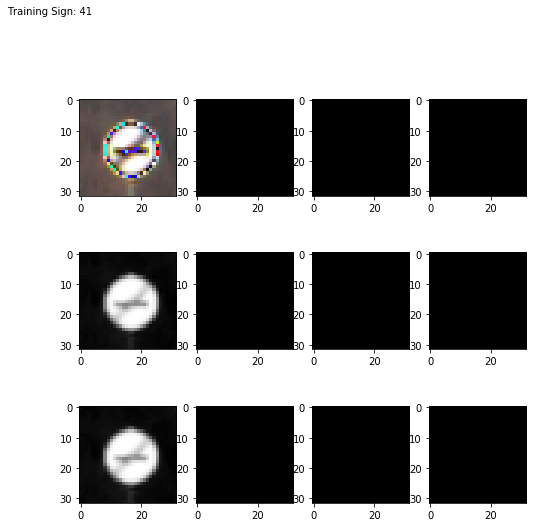

In [7]:
import random

idx = random.randint(0,len(X_test))

img = X_test[idx].squeeze()
lbl = "Training Sign: {}".format(y_test[idx])

imageViz(img,lbl)

### Try RGB

In [8]:
X_test.shape

(12630, 32, 32, 3)

http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

In [27]:
save_file = './rgbNet_10_001_100.ckpt'

# Remove the previous weights and bias
tf.reset_default_graph()

# Get the images and labels
images = tf.placeholder(tf.float32,(None,32,32,3))
labels  = tf.placeholder(tf.int32,(None))
oneHotLabels = tf.one_hot(labels,43)
dropProb = tf.placeholder(tf.float32) # probability of keeping a node in

logits = myRGBNet(images, dropProb)
correctPrediction = tf.equal(tf.argmax(logits, 1), tf.argmax(oneHotLabels, 1))
accuracyOperation = tf.reduce_mean(tf.cast(correctPrediction, tf.float32))

# Launch the graph
with tf.Session() as sess:    
    
    saver = tf.train.import_meta_graph(save_file + '.meta')
    sess.run(tf.global_variables_initializer())
    #saver = tf.train.Saver()
    saver.restore(sess,tf.train.latest_checkpoint('./'))

    #test_accuracy = evaluate(X_test, y_test, batchSize=128, channelCnt=3)
            
    test_accuracy = sess.run(accuracyOperation, feed_dict={images: X_test, labels: y_test, dropProb: 1.0})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.016389546915888786


In [24]:

# Launch the graph
with tf.Session() as sess:    
    
    saver = tf.train.import_meta_graph(save_file + '.meta')
    sess.run(tf.global_variables_initializer())
    #saver = tf.train.Saver()
    saver.restore(sess,save_file)

    #test_accuracy = evaluate(X_test, y_test, batchSize=128, channelCnt=3)
            
    test_accuracy = sess.run(accuracyOperation, feed_dict={images: X_test, labels: y_test, dropProb: 1.0})

    print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.00712589081376791


In [22]:
tf.train.latest_checkpoint('./')

'./rgbGreyNet_10_001_100.ckpt'

In [ ]:
save_file = './rgbNet_10_001_100.ckpt'

# Remove the previous weights and bias
tf.reset_default_graph()

# Two Variables: weights and bias
images = tf.placeholder(tf.float32,(None,32,32,3))
labels  = tf.placeholder(tf.int32,(None))
oneHotLabels = tf.one_hot(labels,43)
dropProb = tf.placeholder(tf.float32) # probability of keeping a node in

# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()

with tf.Session() as sess:
    # Load the weights and bias
    saver.restore(sess, save_file)

    # Show the values of weights and bias
    print('Weight:')
    print(sess.run(weights))
    print('Bias:')
    print(sess.run(bias))


### Try Greyscale

In [6]:
import pickle

testing_file = 'data/test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

# convert to greyscale
X_test = np.array([rgb2Grey(img, weights=[.299,.587,.114]) for img in X_test])

# Normalize the images - zero mean
X_test = np.array([np.array(normalizeGrey(img)) for img in X_test])


    
X_test = X_test.reshape((X_test.shape[0],32,32,1))

In [7]:
X_test.shape

(12630, 32, 32, 1)

In [8]:
save_file = './greyNet_10_001_100.ckpt'
#tf.reset_default_graph()
# Global settings to be used across each implementation
EPOCHS = 10
BATCH_SIZE = 128
LEARN_RATE = 0.001
DROP_PROB = 1.0

outputFrequency = 1

# Get the images and labels
images = tf.placeholder(tf.float32,(None,32,32,1))
labels  = tf.placeholder(tf.int32,(None))
oneHotLabels = tf.one_hot(labels,43)

logits = myGreyNet(images, DROP_PROB)#vgg16(images)#leNet(images)
crossEntropy = tf.nn.softmax_cross_entropy_with_logits(labels=oneHotLabels, logits=logits)
lossOperation = tf.reduce_mean(crossEntropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARN_RATE)
trainingOperation = optimizer.minimize(lossOperation)
correctPrediction = tf.equal(tf.argmax(logits, 1), tf.argmax(oneHotLabels, 1))
accuracyOperation = tf.reduce_mean(tf.cast(correctPrediction, tf.float32))
#saver = tf.train.Saver()



# Launch the graph
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(save_file + '.meta')
    saver.restore(sess,save_file)
    #saver.restore(sess, save_file)
    #sess.run(tf.local_variables_initializer())

    test_accuracy = sess.run(accuracyOperation, feed_dict={images: X_test, labels: y_test})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.015914490446448326


### Try RGB + Greyscale

In [18]:
import pickle

testing_file = 'data/test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

# convert to rgb + greyscale - 4 channels (r,g,b,grey)
X_test = np.array([np.concatenate((img,np.array(rgb2Grey(img, weights=[.299,.587,.114])).reshape(32,32,1)),2) for img in X_test])

# Normalize the images - zero mean
X_test = np.array([np.array(normalizeRGBGrey(img)) for img in X_test])

In [19]:
X_test.shape

(12630, 32, 32, 4)

In [23]:
save_file = './rgbGreyNet_100_001_75.ckpt'
#tf.reset_default_graph()
# Global settings to be used across each implementation
EPOCHS = 10
BATCH_SIZE = 128
LEARN_RATE = 0.001
DROP_PROB = 1.0

outputFrequency = 1

# Get the images and labels
images = tf.placeholder(tf.float32,(None,32,32,4))
labels  = tf.placeholder(tf.int32,(None))
oneHotLabels = tf.one_hot(labels,43)

logits = myRGBGreyNet(images, DROP_PROB)#vgg16(images)#leNet(images)
crossEntropy = tf.nn.softmax_cross_entropy_with_logits(labels=oneHotLabels, logits=logits)
lossOperation = tf.reduce_mean(crossEntropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARN_RATE)
trainingOperation = optimizer.minimize(lossOperation)
correctPrediction = tf.equal(tf.argmax(logits, 1), tf.argmax(oneHotLabels, 1))
accuracyOperation = tf.reduce_mean(tf.cast(correctPrediction, tf.float32))
#saver = tf.train.Saver()



# Launch the graph
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(save_file + '.meta')
    saver.restore(sess,save_file)
    #saver.restore(sess, save_file)
    #sess.run(tf.local_variables_initializer())

    test_accuracy = sess.run(accuracyOperation, feed_dict={images: X_test, labels: y_test})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.026603326201438904


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")